In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import glob

### Reporting points

In [3]:
# points = pd.read_parquet('../data/reporting_points/reporting_points_over_500km2.parquet')

In [4]:
points = pd.read_csv('../data/reporting_points/Station-2022-10-27v12_KGE.csv', index_col='station_id')
points.index.name = 'id'

# filter stations and fields
mask = points.FixedRepPoint == True
cols = ['StationName', 'River', 'EC_Catchments', 'Country code', 'DrainingArea.km2.LDD', 'LSFCalib',
        'LisfloodX', 'LisfloodY', 'Notes', 'KGE', 'correlation', 'bias', 'variability']
points = points.loc[mask, cols]
points.columns = ['name', 'river', 'catchment', 'country', 'area', 'calibrated',
                  'X', 'Y', 'notes', 'KGE', 'correlation', 'bias', 'variability']
points[['strahler', 'pfafstetter']] = np.nan

# mask = points[cols]

print('no. reporting points:\t{0}'.format(points.shape[0]))

no. reporting points:	3337


In [5]:
# load shapefile with edited river and catchment names
points_edited = gpd.read_file('../GIS/fixed_report_points_500.shp')
points_edited.set_index('station_id', inplace=True, drop=True)
points_edited.index = points_edited.index.astype(int)
points_edited = points_edited[['StationNam', 'LisfloodX', 'LisfloodY', 'DrainingAr', 'Subcatchme',
                               'River', 'Catchment', 'Country co', 'strahler', 'pfafstette']]
points_edited.columns = ['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country', 'strahler', 'pfafstetter']
points_edited['KGE'] = np.nan
# select points with a Pfafstetter code
mask = points_edited.pfafstetter.isnull()
points_edited = points_edited.loc[~mask]

In [6]:
# correct names of catchments and rivers
ids = points_edited.index #list(set(stations.index).intersection(points_edited.index))
# stations = stations.loc[ids]
for id in ids:
    for col in ['subcatchment', 'river', 'catchment']:
        if points_edited.loc[id, col] != np.nan:
            points.loc[id, col] = points_edited.loc[id, col]

# add subcatchment and river order
points.loc[ids, ['strahler', 'pfafstetter']] = points_edited.loc[ids, ['strahler', 'pfafstetter']]

print('no. stations:\t{0}'.format(points.shape[0]))

points = points[['name', 'river', 'subcatchment', 'catchment', 'country', 'area', 'strahler', 'pfafstetter', 'calibrated', 'X', 'Y',
                 'notes', 'KGE', 'correlation', 'bias', 'variability']]

points[['X', 'Y', 'area']] = points[['X', 'Y', 'area']].astype(int)

no. stations:	3337


In [7]:
# select points that have been identified to be negatively affected by dams
points.notes.replace(np.nan, '', inplace=True)
mask_dams = points.notes.str.contains('dam', case=False)
points_dam = points[mask_dams]

print('no. reporting points:\t{0}'.format(points_dam.shape[0]))

no. reporting points:	104


In [8]:
points_dam[points_dam.river == 'Segura']

,name,river,subcatchment,catchment,country,area,strahler,pfafstetter,calibrated,X,Y,notes,KGE,correlation,bias,variability
id,,,,,,,,,,,,,,,,
2792,Segura En Almadenes,Segura,Segura,Segura,ES,7475,1.0,1.0,True,3307500,1762500,Dam,-0.014,-0.009,1.020,1.104
2988,Fuensanta,Segura,Segura,Segura,ES,1875,1.0,1.0,False,3257500,1787500,Moved downstream of dam strongly regulated wit...,0.294,0.463,0.652,1.299
2989,Cenajo,Segura,Segura,Segura,ES,2650,1.0,1.0,True,3292500,1777500,Moved downstream of dam strongly regulated wi...,-0.065,0.126,0.516,0.633


In [9]:
points_dam[points_dam.catchment == 'Douro']

,name,river,subcatchment,catchment,country,area,strahler,pfafstetter,calibrated,X,Y,notes,KGE,correlation,bias,variability
id,,,,,,,,,,,,,,,,
3012,Cuerda del Pozo,Douro,Douro,Douro,ES,575,1.0,19511.0,True,3272500,2172500,moved downstream of dam strongly regulated,0.024,0.152,0.531,1.113
3013,Cernadilla,Tera,Esla,Douro,ES,650,3.0,14411.0,True,2967500,2247500,Moved downstream of dam,0.432,0.611,0.587,0.966
3014,Aguilar de campoo,Pisuerga,Pisuerga,Douro,ES,875,2.0,18711.0,False,3157500,2297500,Moved downstream of dam close to 1190,-0.035,0.052,0.897,1.402
3017,Santa Teresa,Tormes,Tormes,Douro,ES,2225,2.0,12111.0,True,3007500,2092500,Moved downstream of dam,0.314,0.396,0.706,0.859
3018,Almendra,Tormes,Tormes,Douro,ES,7100,2.0,12111.0,False,2957500,2167500,moved downstream of dam extremely large oscil...,0.058,0.160,0.576,1.047
3019,Riano,Esla,Esla,Douro,ES,700,1.0,14931.0,True,3092500,2327500,moved downstream of dam strongly regulated,-0.124,-0.103,0.788,1.037


In [10]:
points_dam.river.value_counts().head(20)

Drava                  4
Jiloca                 3
Noguera Ribagorzana    3
Jucar                  3
Segura                 3
Thaya                  2
Ebro                   2
Tagus                  2
Lot                    2
Guadalen               2
Lech                   2
Tormes                 2
Drina                  2
Kemijoki               2
Kitinen                2
Guadiana               2
Loire                  2
Mijares                1
Guadiato               1
Zschopau               1
Name: river, dtype: int64

In [39]:
points_dam.catchment.value_counts()

Danube                        25
Ebro                          13
Douro                          6
Tagus                          5
Guadalquivir                   4
Kemijoki                       4
Jucar                          4
Elbe                           3
Loire                          3
Garonne                        3
Segura                         3
Minho                          3
Rhone                          3
Guadiana                       2
Rhine                          2
Corrib                         1
Kokem                          1
Mijares                        1
Nidelva                        1
Kuban                          1
Kola                           1
Kymijoki - Gulf of Finland     1
Neva                           1
Lagarfljot                     1
Weser                          1
Paatsjoki                      1
Gota                           1
Dordogne                       1
Neretva                        1
Lima                           1
Skien     

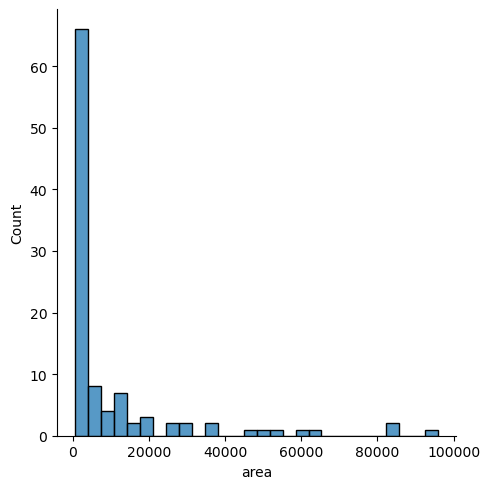

In [40]:
sns.displot(points_dam.area);

In [41]:
points.to_csv('../data/reporting_points/reporting_points.csv')

### Reservoirs

In [7]:
reservoirs = pd.read_csv('../data/reservoirs/EFAS/EFAS_HRES_Reservoirs_metadata.csv', index_col='ResID')

print('no. reservoirs:\t{0}'.format(reservoirs.shape[0]))

reservoirs.head()

no. reservoirs:	1423


,TAG,SOURCE,TYPE,COUNTRY,DAM_NAME,ACTIVE_FRO,LON_ORG,LAT_ORG,LisfloodX,LisfloodY
ResID,,,,,,,,,,
1,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,NEGRATIN_5043,1984,-2.984430,37.551195,-2.94167,37.55833
2,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,GUADALEN_5004,1954,-3.496655,38.170242,-3.47500,38.17500
3,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,GUADALMENA_5018,1969,-2.898295,38.378933,-2.90833,38.35833
4,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,GIRIBAILE_5070,1996,-3.488523,38.125808,-3.47500,38.09167
5,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,RUMBLAR_5005,0,-3.787174,38.179195,-3.80833,38.17500


In [8]:
attributes = pd.DataFrame()
for file in glob.glob('../data/reservoirs/EFAS/r*.txt'):
    var = file.split('\\')[1].split('.')[0]
    df = pd.read_csv(file, header=None, sep=' ')
    df.columns = ['Resid', var]
    df.set_index('Resid', inplace=True, drop=True)
    attributes = pd.concat((attributes, df), axis=1)
    
print('no. reservoirs:\t{0}'.format(attributes.shape[0]))

attributes = attributes.rename(columns={'rclim': 'Scons', 'rflim': 'Sflood', 'rminq': 'Qmin', 'rndq': 'Qnd', 'rnlim': 'Snorm', 'rnormq': 'Qnorm', 'rtstor': 'S'})
attributes = attributes[['Scons', 'Snorm', 'Sflood', 'S', 'Qmin', 'Qnorm', 'Qnd']]
for var in ['Scons', 'Snorm', 'Sflood']:
    attributes[var] *= attributes.S

attributes.head()

no. reservoirs:	1457


,Scons,Snorm,Sflood,S,Qmin,Qnorm,Qnd
Resid,,,,,,,
1,56710000.0,283550000.0,550087000.0,567100000.0,1.6,4.8,84.0
2,16800000.0,84000000.0,162960000.0,168000000.0,0.2,0.8,15.0
3,34650000.0,173250000.0,336105000.0,346500000.0,0.3,1.2,11.0
4,47510000.0,237550000.0,460847000.0,475100000.0,0.1,0.7,27.0
5,12600000.0,63000000.0,122220000.0,126000000.0,0.2,0.5,6.0


<font color='red'>More reservoirs in the attributes than in the metada!!</font>

In [28]:
res = xr.open_dataarray('../data/reservoirs/EFAS/res_European_01min.nc')

res_id = np.unique(res.data)
res_id = res_id[~np.isnan(res_id)].astype(int)

print('no. reservoirs:\t{0}'.format(len(res_id)))

no. reservoirs:	1420


In [29]:
set(reservoirs.index) - set(res_id)

{3132, 4043, 4048}

In [30]:
reservoirs.loc[[3132, 4043, 4048]]

,TAG,SOURCE,TYPE,COUNTRY,DAM_NAME,ACTIVE_FRO,LON_ORG,LAT_ORG,LisfloodX,LisfloodY
ResID,,,,,,,,,,
3132,,GranD,,Spain,Cenza,0,0.0,0.0,-0.00833,22.75833
4043,,GranD,,Bosnia and Herzegovina,Snjeznica,0,0.0,0.0,-0.00833,22.75833
4048,,GranD,,Bosnia and Herzegovina,Zvornik,0,0.0,0.0,-0.00833,22.75833


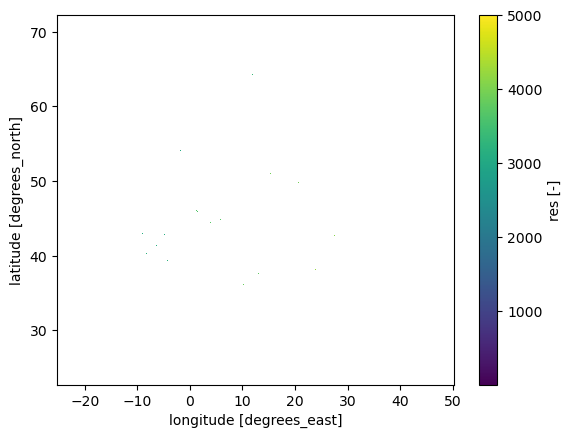

In [31]:
res.plot();

In [11]:
set(attributes.index) - set(reservoirs.index)

{41,
 53,
 66,
 68,
 71,
 74,
 75,
 76,
 79,
 80,
 81,
 84,
 85,
 86,
 89,
 90,
 92,
 98,
 103,
 107,
 110,
 111,
 112,
 120,
 122,
 131,
 3322,
 3333,
 3337,
 3339,
 3402,
 3878,
 4046,
 4209}

In [35]:
pd.concat((reservoirs.loc[res_id], attributes.loc[res_id]), axis=1)

,TAG,SOURCE,TYPE,COUNTRY,DAM_NAME,ACTIVE_FRO,LON_ORG,LAT_ORG,LisfloodX,LisfloodY,Scons,Snorm,Sflood,S,Qmin,Qnorm,Qnd
1,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,NEGRATIN_5043,1984,-2.984430,37.551195,-2.94167,37.55833,5.671000e+07,2.835500e+08,5.500870e+08,5.671000e+08,1.6,4.80,84.00
2,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,GUADALEN_5004,1954,-3.496655,38.170242,-3.47500,38.17500,1.680000e+07,8.400000e+07,1.629600e+08,1.680000e+08,0.2,0.80,15.00
3,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,GUADALMENA_5018,1969,-2.898295,38.378933,-2.90833,38.35833,3.465000e+07,1.732500e+08,3.361050e+08,3.465000e+08,0.3,1.20,11.00
4,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,GIRIBAILE_5070,1996,-3.488523,38.125808,-3.47500,38.09167,4.751000e+07,2.375500e+08,4.608470e+08,4.751000e+08,0.1,0.70,27.00
5,ERM,Peter_Spain,RESERVOIR_M_EUR,Spain,RUMBLAR_5005,0,-3.787174,38.179195,-3.80833,38.17500,1.260000e+07,6.300000e+07,1.222200e+08,1.260000e+08,0.2,0.50,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4274,ERS,GranD,RESERVOIR_S_EUR,Libya,Qattara,1973,20.406250,32.027083,20.40833,32.02500,1.350000e+07,6.750000e+07,1.309500e+08,1.350000e+08,0.0,0.42,12.14
4275,ERS,GranD,RESERVOIR_S_EUR,Egypt,Assiut Barrage,1902,31.189583,27.202083,31.19167,27.20833,1.000000e+10,5.000000e+10,9.700000e+10,1.000000e+11,1200.0,5500.00,10000.00
5001,HPROT,Cinzia,RETENTION_AREA,Croatia,Sava retention area 1,0,16.292075,45.538071,16.39167,45.54167,3.160000e+07,1.580000e+08,3.065200e+08,3.160000e+08,100.0,1100.00,1600.00
5002,HPROT,Cinzia,RETENTION_AREA,Croatia,Sava retention area 2,0,16.599903,45.428885,16.59167,45.42500,6.340000e+07,3.170000e+08,6.149800e+08,6.340000e+08,120.0,1600.00,2000.00
